# Introduction

This example demonstrates using a network pretrained on ImageNet for classification. The model used was converted from the VGG_CNN_S model (http://arxiv.org/abs/1405.3531) in [Caffe's Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). 

For details of the conversion process, see the example notebook "Using a Caffe Pretrained Network - CIFAR10".

### License
The model is licensed for non-commercial use only

### Download the model (393 MB)

In [1]:
#!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg_cnn_s.pkl
import sys
sys.path.append('../../coco/PythonAPI')
import os
from pycocotools.coco import COCO
import numpy as np
from numpy import reshape
import skimage.io as io
import matplotlib.pyplot as plt
#modulename = importlib.machinery.SourceFileLoader('modulename','/Path/To/module.py').load_module()


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import json
with open('../../coco/annotations/instances_train2014.json') as data_file:
    data = json.load(data_file)

In [3]:
dataDir='../../coco'
dataType='train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
cocoTrain=COCO(annFile)
dataType='val2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
cocoVal=COCO(annFile)

loading annotations into memory...
Done (t=16.97s)
creating index...
index created!
loading annotations into memory...
Done (t=10.20s)
creating index...
index created!


In [4]:
#Define a function which can read images, resize them to height x width and save the resized image in place of the original
from PIL import Image
def resizer(directory,width,height):
    i = 0
    for filename in os.listdir(directory):
        if i%1000 == 0:
            print(i)
        # Open the image file.
        img = Image.open(os.path.join(directory, filename))
        # Resize it.
        img = img.resize((width, height), Image.BILINEAR)
        # Save it back to disk.
        img.save(os.path.join(directory, filename))
        i += 1
    print('Batch processing complete.')
#resizer('../../coco/train2014',224,224)
#resizer('../../coco/val2014',224,224)
#resizer('../../coco/test2014',224,224)

In [5]:
#Define a function which checks if images have dimensions (height, width,3). If not, delete the image
def wrongShapeDeleter(directory, height, width):
    counter = 0
    for filename in os.listdir(directory):
        img = io.imread('%s/%s'%(directory,filename))
        if img.shape != (height, width, 3):
            counter += 1
            #If the image has some other shape than (height, width), i.e. grayscale, we want to see it
            if img.shape != (height, width):
                print(filename, img.shape)
            else:
                os.remove('%s/%s'%(directory,filename))
    print directory, counter
#wrongShapeDeleter('../../coco/train2014',224,224)
#wrongShapeDeleter('../../coco/val2014',224,224)
#wrongShapeDeleter('../../coco/test2014',224,224)

In [6]:
cats = cocoTrain.loadCats(cocoTrain.getCatIds())
#print(cats)
validCatIds = [x['id'] for x in cats]
print(validCatIds)
yo = cocoTrain.loadImgs(185652)
#print(yo[0]['id'])
yo2 = cocoTrain.loadAnns(ids=[185652])
#print(yo2[0]['category_id'])
yoyo = cocoTrain.getImgIds()
#print(yo2[0])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]


In [7]:
#Some image files have been deleted by us because they only contained 1 channel. 
#However, the function coco.getImgIds doesn't "know" this. 
#Therefore we must have a list of which files have been deleted.
def deletedFileLister(directory,coco):
    existingFileNames = os.listdir(directory)
    allImgIds = coco.getImgIds()
    deletedFileNames = []
    for i in range(len(allImgIds)):
        if i%1000==0:
            print i
        tempImg = coco.loadImgs(allImgIds[i])
        if not(tempImg[0]['file_name'] in existingFileNames):
            deletedFileNames.append(tempImg[0]['file_name'])
    return deletedFileNames

#trainDeletedFiles = deletedFileLister('../../coco/train2014', cocoTrain)
#valDeletedFiles = deletedFileLister('../../coco/val2014', cocoVal)

import pickle
#with open('listsOfDeletedFiles','w') as f:
#    pickle.dump([trainDeletedFiles,valDeletedFiles],f)
allDeletedFiles = pickle.load(open('listsOfDeletedFiles', 'rb'))
trainDeletedFiles = allDeletedFiles[0]
valDeletedFiles = allDeletedFiles[1]

In [8]:
def getXandY(coco,minimumCatCount,validCatIds,fileDirectory,deletedFileNames):
    allFileNames = os.listdir(fileDirectory)
    allImgIds = coco.getImgIds()
    singleCatImgIds = []
    allAnnIds = coco.getAnnIds(imgIds=allImgIds);
    myDict = {}
    counter = 0
    for i in range(len(allImgIds)):
        #tempAnns = coco.loadAnns(ids=allAnnIds[i])
        tempAnns = coco.loadAnns(coco.getAnnIds(imgIds=allImgIds[i]))
        tempImg = coco.loadImgs(allImgIds[i])
        #if("train" in tempImg[0]['file_name']):
        #    print "Brarp brarp",allImgIds[i], tempImg[0]['file_name']
        allCategoriesList = []
        #Find all categories associated with the current image
        for x in tempAnns:
            allCategoriesList.append(x['category_id'])
        allCategoriesList = set(allCategoriesList)
        #Images are included in training or validation set if they are associated with exactly one category 
        #and if they have not been deleted.
        if len(allCategoriesList)==1 and not(tempImg[0]['file_name'] in deletedFileNames):
            counter += 1
            myDict[allImgIds[i]] = [tempAnns[0]['category_id'], tempImg[0]['file_name']]
            singleCatImgIds.append(allImgIds[i])
    allSingleCategories = [x[0] for x in list(myDict.values())]
    categoryCounts = {x:allSingleCategories.count(x) for x in validCatIds}
    plentifulCategories = [x for x in validCatIds if categoryCounts[x]>=minimumCatCount]
    plentifulCategoryCounts = {x:categoryCounts[x] for x in plentifulCategories}
    plentifulImageIds = [x for x in list(myDict.keys()) if myDict[x][0] in plentifulCategories]
    plentifulDict = {k:myDict[k] for k in plentifulImageIds}
    return [plentifulDict, plentifulCategories, plentifulCategoryCounts]

trainList = getXandY(cocoTrain, 100, validCatIds, '../../coco/train2014', trainDeletedFiles)
trainDict = trainList[0]
#The validation set should only contain categories which are also in the training set. 
#Therefore we pass the category ids from the training set as validCatIds
valList = getXandY(cocoVal, 50, trainList[1], '../../coco/val2014', valDeletedFiles)
valDict = valList[0]
num_classes = len(trainList[1])

In [9]:
print "Number of images in training set:",len(trainList[0]) 
print "Number of images in validation set:",len(valList[0])
#Ensure that validation does not have less categories than training set
print "Training and val. set have the same categories:", trainList[1]==valList[1] 


Number of images in training set: 15423
Number of images in validation set: 7701
Training and val. set have the same categories: True


In [10]:
dataDir = "../../coco"
dataType = "../../coco"
allFiles = os.listdir('../../coco/train2014')
height = 224
width = 224
N = 1
x_train = []
x_train = np.empty([N,3,height,width])
i = 0
j = 0
for filename in allFiles:
    i += 1
    if i>N-1:
        break
    if i%100 == 0:
        print(i)
    #print(i)
    I = io.imread('%s/%s/%s'%(dataDir,'train2014',filename))
    if I.shape == (height, width, 3):
        x_train[j,:,:,:] = np.transpose(I,(2,0,1))
        j += 1
    else:
        print("yo",i)
    #x_train[i,:,:,:] = np.transpose(io.imread('%s/%s/%s'%(dataDir,'train2014',filename)),(2,0,1))

In [11]:
x_train.shape

(1, 3, 224, 224)

In [12]:
#print(x_train.shape)
#plt.figure()
#plt.imshow(I[0,:,:])
#plt.show()

# Setup

In [13]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.layers import LocalResponseNormalization2DLayer as NormLayer
from lasagne.utils import floatX

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 4007)


### Define the network

In [15]:
net = {}
net['input'] = InputLayer((None, 3, 224, 224))
net['conv1'] = ConvLayer(net['input'], num_filters=96, filter_size=7, stride=2, flip_filters=False)
net['norm1'] = NormLayer(net['conv1'], alpha=0.0001) # caffe has alpha = alpha * pool_size
net['pool1'] = PoolLayer(net['norm1'], pool_size=3, stride=3, ignore_border=False)
net['conv2'] = ConvLayer(net['pool1'], num_filters=256, filter_size=5, flip_filters=False)
net['pool2'] = PoolLayer(net['conv2'], pool_size=2, stride=2, ignore_border=False)
net['conv3'] = ConvLayer(net['pool2'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
net['conv4'] = ConvLayer(net['conv3'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
net['conv5'] = ConvLayer(net['conv4'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
net['pool5'] = PoolLayer(net['conv5'], pool_size=3, stride=3, ignore_border=False)
net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
net['drop6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['drop6'], num_units=4096)
net['drop7'] = DropoutLayer(net['fc7'], p=0.5)
#net['fc8'] = DenseLayer(net['drop7'], num_units=1000, nonlinearity=lasagne.nonlinearities.softmax)
net['fc8Modified'] = DenseLayer(net['drop7'], num_units=num_classes, nonlinearity=lasagne.nonlinearities.softmax)
output_layer = net['fc8Modified']
#output_layer = net['pool5']

In [17]:
import pickle

model = pickle.load(open('vgg_cnn_s.pkl'))
CLASSES = model['synset words']
MEAN_IMAGE = model['mean image']
for i in range(10,len(model['values'])-2):
    print(i, model['values'][i].shape)
    model['values'][i].fill(0)
    
# If we do not cast to float32 we get this error: 
#TypeError: ('CudaNdarrayType(float32, vector), with dtype float32, 
#cannot store a value of dtype float64 without risking loss of precision.
#If you do not mind, please cast your data to float32.'
model['values'][14] = np.random.normal(0,1,(4096,num_classes)).astype(np.float32)
model['values'][15] = np.random.normal(0,1,(num_classes,)).astype(np.float32)

#lasagne.layers.set_all_param_values(output_layer, model['values'])
#lasagne.layers.set_all_param_values(output_layer, model["values"][0:10])
print('')
for i in range(len(model['values'])):
    print(i, model['values'][i].shape)
lasagne.layers.set_all_param_values(output_layer, model['values'])
#lasagne.layers.get_all_param_values(output_layer)
#lasagne.layers.set_all_param_values(output_layer, model["values"][0:10]

(10, (18432, 4096))
(11, (4096,))
(12, (4096, 4096))
(13, (4096,))

(0, (96, 3, 7, 7))
(1, (96,))
(2, (256, 96, 5, 5))
(3, (256,))
(4, (512, 256, 3, 3))
(5, (512,))
(6, (512, 512, 3, 3))
(7, (512,))
(8, (512, 512, 3, 3))
(9, (512,))
(10, (18432, 4096))
(11, (4096,))
(12, (4096, 4096))
(13, (4096,))
(14, (4096, 35))
(15, (35,))


In [18]:
import theano
import theano.tensor as T
#Setting up the graph in theano
sym_x = T.tensor4('sym_x') # a symbolic variable, this is now a 4-D tensor.
sym_t = T.ivector('sym_t') # a symbolic variable taking on the value of the target batch.

# Retrieve network output
train_out = lasagne.layers.get_output(output_layer, sym_x, deterministic=False)
eval_out = lasagne.layers.get_output(output_layer, sym_x, deterministic=True)

# Retrieve list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(output_layer, trainable=True)

#Define our cost function
cost = T.nnet.categorical_crossentropy(train_out+1e-8, sym_t).mean()

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)

# Set the update function for parameters 
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.005)

#f_val takes x and t and passes them to the cost function.
f_val = theano.function([sym_x, sym_t],
                         [cost],on_unused_input='warn')

f_eval = theano.function([sym_x],
                     eval_out, on_unused_input='warn')

f_train = theano.function([sym_x, sym_t],
                          [cost],
                          updates=updates, on_unused_input='warn')

In [19]:
#Test the forward pass
x = np.random.normal(0,1, (1, 3,224,224)).astype('float32') #dummy data

model = lasagne.layers.get_output(output_layer, sym_x)
out = model.eval({sym_x:x}) #this could also include mask etc if used
print("l_out", out.shape)
print(out)
print(len(out[0]))

('l_out', (1, 35))
[[ 0.00573412  0.00189851  0.05137583  0.05160396  0.03242445  0.0148798
   0.02084348  0.04799204  0.01843948  0.00634624  0.01365648  0.01311927
   0.02339642  0.11741142  0.00976253  0.01768353  0.01453859  0.05489423
   0.01004529  0.00449029  0.02105397  0.00550207  0.05112619  0.02883563
   0.05774292  0.00480784  0.04062595  0.00292632  0.0969478   0.01547325
   0.01732507  0.01887388  0.05096025  0.00173963  0.05552327]]
35


In [25]:
#Create dict which goes from category ID to target vector
plentifulCategories = trainList[1]
targets = np.arange(len(plentifulCategories)).astype(np.int32)
catIdToTargetDict = {x:y for x, y in zip(plentifulCategories, targets)}
#for i in range(len(plentifulCategories)):
#    target = np.zeros(len(plentifulCategories))
#    target[i] = 1
#    catIdToTargetDict[plentifulCategories[i]] = target

#Create function which reads images based on file names and puts them all into a numpy array
def imgReader(directory, fileNames, imageShape, MEAN_IMAGE):
    imgArray = np.zeros((len(fileNames),imageShape[0],imageShape[1],imageShape[2]))
    for i in range(len(fileNames)):
        img = io.imread('%s/%s'%(directory,fileNames[i]))
        img = np.transpose(img,(2,0,1))
        imgArray[i,:,:,:] = img - MEAN_IMAGE
    return imgArray.astype(np.float32)
        

0.0
6.49350649351
12.987012987
19.4805194805
25.974025974
32.4675324675
38.961038961
45.4545454545
51.9480519481
58.4415584416
64.9350649351
71.4285714286
77.9220779221
84.4155844156
90.9090909091
97.4025974026
1 loop done
0.0
3.24675324675
6.49350649351
9.74025974026
12.987012987
16.2337662338
19.4805194805
22.7272727273
25.974025974
29.2207792208
32.4675324675
35.7142857143
38.961038961
42.2077922078
45.4545454545
48.7012987013
51.9480519481
55.1948051948
58.4415584416
61.6883116883
64.9350649351
68.1818181818
71.4285714286
74.6753246753
77.9220779221
81.1688311688
84.4155844156
87.6623376623
90.9090909091
94.1558441558
97.4025974026
2 loop done
0.0
6.49350649351
12.987012987
19.4805194805
25.974025974
32.4675324675
38.961038961
45.4545454545
51.9480519481
58.4415584416
64.9350649351
71.4285714286
77.9220779221
84.4155844156
90.9090909091
97.4025974026
103.896103896
110.38961039
116.883116883
123.376623377
129.87012987
136.363636364
142.857142857
149.350649351
155.844155844
162.33766

ValueError: x and y must have same first dimension

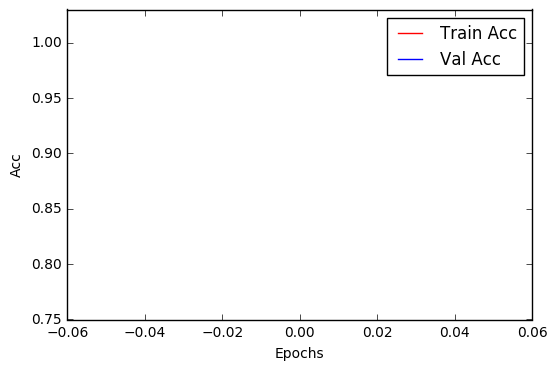

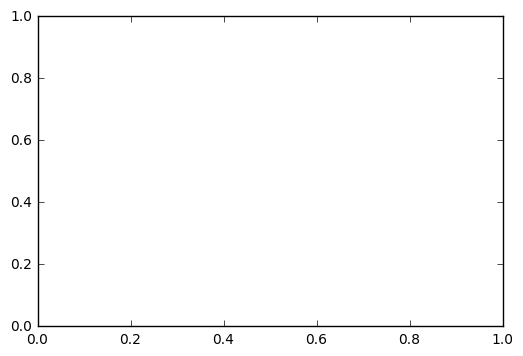

In [26]:
#Training Loop
from confusionmatrix import ConfusionMatrix
batch_size = 50
batch_size_valid = 10
num_epochs = 4
num_samples_train = len(trainDict)#x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = len(valDict)#x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size
num_classes = len(trainList[1])

fileNames_train = np.array([x[1] for x in trainDict.values()])
targets_train = np.array([catIdToTargetDict[x[0]] for x in trainDict.values()])
fileNames_valid = np.array([x[1] for x in valDict.values()])
targets_valid = np.array([catIdToTargetDict[x[0]] for x in valDict.values()])
imageShape = [3,224,224]


train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
loss_valid = []
try:
    for epoch in range(num_epochs):
        
        #Own code
        cur_loss_d = 0
        for i in range(num_batches_valid):
            if i%10 == 0:
                print i/float(num_batches_valid)*100
            #print(i/float(num_batches_valid)*100)
            idx_d = range(i*batch_size_valid, (i+1)*batch_size_valid)
            filenames_batch_d = fileNames_valid[idx_d]
            x_batch_d = imgReader('../../coco/val2014', filenames_batch_d,imageShape, MEAN_IMAGE)
            target_batch_d = targets_valid[idx_d]    
            batch_loss_d = f_val(x_batch_d,target_batch_d)
            cur_loss_d += batch_loss_d[0]
        loss_valid += [cur_loss_d/batch_size_valid]
        print "1 loop done"
        #Forward->Backprob->Update params
        cur_loss = 0
        for i in range(num_batches_train):
            if i%10 == 0:
                print i/float(num_batches_train)*100
            #print(i/float(num_batches_train)*100)
            idx = range(i*batch_size, (i+1)*batch_size)
            filenames_batch = fileNames_train[idx]
            x_batch = imgReader('../../coco/train2014', filenames_batch, imageShape, MEAN_IMAGE)
            target_batch = targets_train[idx]    
            batch_loss = f_train(x_batch,target_batch) #this will do the complete backprob pass
            cur_loss += batch_loss[0]
        loss += [cur_loss/batch_size]
        print "2 loop done"

        confusion_valid = ConfusionMatrix(num_classes)
        confusion_train = ConfusionMatrix(num_classes)

        for i in range(num_batches_train):
            if i%10 == 0:
                print i/float(num_batches_valid)*100
            #print(i/float(num_batches_train)*100)
            idx = range(i*batch_size, (i+1)*batch_size)
            filenames_batch = fileNames_train[idx]
            x_batch = imgReader('../../coco/train2014', filenames_batch, imageShape, MEAN_IMAGE)
            targets_batch = targets_train[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 
            confusion_train.batch_add(targets_batch, preds)
        print "3 loop done"
        confusion_valid = ConfusionMatrix(num_classes)
        for i in range(num_batches_valid):
            if i%10 == 0:
                print i/float(num_batches_valid)*100
            #print(i/float(num_batches_valid)*100)
            idx = range(i*batch_size_valid, (i+1)*batch_size_valid)
            filenames_batch_d = fileNames_valid[idx_d]
            x_batch = imgReader('../../coco/val2014', filenames_batch_d,imageShape, MEAN_IMAGE)
            targets_batch = targets_valid[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 

            confusion_valid.batch_add(targets_batch, preds)
        print "4 loop done"
        train_acc_cur = confusion_train.accuracy()
        valid_acc_cur = confusion_valid.accuracy()

        train_acc += [train_acc_cur]
        valid_acc += [valid_acc_cur]
        print "Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
        % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur)
except KeyboardInterrupt:
    pass
    

#get test set score
#confusion_test = ConfusionMatrix(num_classes)
#net_out = f_eval(x_test)    
#preds = np.argmax(net_out, axis=-1) 
#confusion_test.batch_add(targets_test, preds)
#print "\nTest set Acc:  %f" %(confusion_test.accuracy())


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

plt.figure()
plt.plot(epoch,loss,'r',epoch,loss_valid,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.ylim([0,0.2])

In [ ]:
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0, 0.1])

plt.figure()
plt.plot(epoch,loss,'r',epoch,loss_valid,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.ylim([0,30])

In [ ]:
#yo = os.listdir('../../coco/val2014')
#'COCO_val2014_000000458311.jpg' in yo
#print("val" in 'COCO_val2014_000000458311.jpg')
#for i in range(len(fileNames_train)):
#    if "val" in fileNames_train[i]:
#        print(i)

### Load the model parameters and metadata

In [24]:
MEAN_IMAGE[:,:,:].shape

(3, 224, 224)

In [ ]:
model["values"][0].shape

# Trying it out

### Get some test images
We'll download the ILSVRC2012 validation URLs and pick a few at random

In [ ]:
import urllib

index = urllib.urlopen('http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html').read()
image_urls = index.split('<br>')

np.random.seed(25)
np.random.shuffle(image_urls)
image_urls = image_urls[:5]

In [ ]:
image_urls = ["http://farm1.staticflickr.com/15/22703851_729cd2cd04.jpg"]

### Helper to fetch and preprocess images

In [ ]:
import io
import skimage.transform

def prep_image(url):
    ext = url.split('.')[-1]
    im = plt.imread(io.BytesIO(urllib.urlopen(url).read()), ext)
    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_IMAGE
    return rawim, floatX(im[np.newaxis])

### Process test images and print top 5 predicted labels

In [ ]:
import skimage.io as io
for url in image_urls:
    try:
        #rawim, im = prep_image(url)
        im = io.imread('%s/%s/%s'%(dataDir,'train2014',allFiles[16]))
        rawim = np.copy(im).astype('uint8')
        im = np.transpose(im,(2,0,1))
        im = np.reshape(im,(1,3,224,224))
        print(im.shape)
        im = im - MEAN_IMAGE
        prob = np.array(lasagne.layers.get_output(output_layer, im, deterministic=True).eval())
        top5 = np.argsort(prob[0])[-1:-6:-1]

        plt.figure()
        plt.imshow(rawim.astype('uint8'))
        plt.axis('off')
        for n, label in enumerate(top5):
            plt.text(250, 70 + n * 20, '{}. {}'.format(n+1, CLASSES[label]), fontsize=14)
    except IOError:
        print('bad url: ' + url)

In [ ]:
print(CLASSES)